## Оценка результатов A/B-теста.

Цели и предоставленные данные

**Цель исследования - провести оценку результатов A/B-теста:**
- оценить корректность проведения теста
- проанализировать результаты теста


Для анализа предоставлены: техническое задание, датасет с действиями пользователей и несколько вспомогательных датасетов.

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    


**Описание данных**

**ab_project_marketing_events.csv** — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

**final_ab_new_users.csv** — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

**final_ab_events.csv** — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

**final_ab_participants.csv** — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [70]:
# импорт библиотек
import pandas as pd
import numpy as np
import math as mth
from datetime import datetime as dt, timedelta
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

In [71]:
# загружаем данные
ab_users = pd.read_csv('/datasets/final_ab_new_users.csv')
ab_events = pd.read_csv('/datasets/final_ab_events.csv')
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
ab_participance = pd.read_csv('/datasets/final_ab_participants.csv')

## Предобработка данных

In [72]:
def preview (data):
    '''Обзорная функция по датасету'''
    if str(data) == str(ab_users):
        print('--------------------------------------------------------')
        print('Посмотрим данные ab_users')
        print()
    elif str(data) == str(marketing_events):
        print('--------------------------------------------------------')
        print('Посмотрим данные marketing_events')
        print()
    elif str(data) == str(ab_participance):
        print('--------------------------------------------------------')
        print('Посмотрим таблицу ab_participance')
        print()
    else:
        print('--------------------------------------------------------')
        print('Посмотрим данные ab_events')
        print()
    data.info()
    display(data.head())
    print(f'Полных дубликатов -', data.duplicated().sum())

In [73]:
# смотрим обзор по таблицам
data_list = [ab_users, ab_events, ab_participance, marketing_events]
for i in data_list:
    preview(i)

--------------------------------------------------------
Посмотрим данные ab_users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Полных дубликатов - 0
--------------------------------------------------------
Посмотрим данные ab_events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Полных дубликатов - 0
--------------------------------------------------------
Посмотрим таблицу ab_participance

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Полных дубликатов - 0
--------------------------------------------------------
Посмотрим данные marketing_events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Полных дубликатов - 0


- **ab_users** - Пропусков и полных дублей нет, нужно преобразовать тип в столбце о времени
- **ab_events** - Есть пропуски, далее проверим их; нужно заменить тип данных для столбца о времени, полных дублей нет
- **ab_participance** - Пропусков и полных дублей нет
- **marketing_events** -  Пропусков и полных дублей нет, нужно преобразовать тип в столбце о времени

In [74]:
def date_type(date):
    '''Преобразование к типу datetime'''
    date_new = pd.to_datetime(date)
    return date_new

In [75]:
#приводим к нужному типу данных
ab_users['first_date'] = date_type(ab_users['first_date'])
ab_events['event_dt'] = date_type(ab_events['event_dt'])
marketing_events['start_dt'] = date_type(marketing_events['start_dt'])
marketing_events['finish_dt'] = date_type(marketing_events['finish_dt'])

In [76]:
ab_events['event_day'] = pd.to_datetime(ab_events['event_dt']).dt.date

In [77]:
for i in data_list:
    i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
 4   event_day   440317 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 16.8+ MB
<class 'pandas.core.

Ок, все типы данных приведены к нужным.

Проверка пропусков

In [78]:
#доля пропусков
round((ab_events['details'].isna().sum()/len(ab_events)),2)

0.86

Мы знаем, что этот столбец содержит дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах. Проверим с какими действиями связаны заполненные значения

In [79]:
#уточняем есть ли в details пропуски при фильтрации по purchase, и какой длины этот срез
print(
    ab_events[ab_events['event_name'] == 'purchase']['details'].isna().sum(),
    len(ab_events[ab_events['event_name'] == 'purchase'])
)

0 62740


Длина среза по purchase равна количеству заполненных значений в столбце details - это дополнительные данные только о событии purchase, соответственно остальные данные пока видимо не заполнялись. Оставим пропуски как есть.

### Итоги

**Дубликатов во всех датасетах не найдено, пропуски есть только в ab_events и связаны с особенностями формирования данных, пропуски оставили.**

## Проверка технического задания

Обратим внимание на то, что количество записей в столбцах таблиц ab_users, ab_participance  разное. В обеих таблицах есть user_id, кроме того user_id есть и в ab_events. Посмотрим количество уникальных user_id в каждой их этих таблиц, эти данные будут полезны при проверке ТЗ.

In [80]:
print(
    ab_users['user_id'].nunique(), '- уникальные user_id в таблице ab_users;', len(ab_users), '-всего записей\n',
    ab_events['user_id'].nunique(), '- уникальные user_id в таблице ab_events;', len(ab_events), '-всего записей\n',
    ab_participance['user_id'].nunique(), '- уникальные user_id в таблице ab_participance',
    len(ab_participance), '-всего записей' 
)

61733 - уникальные user_id в таблице ab_users; 61733 -всего записей
 58703 - уникальные user_id в таблице ab_events; 440317 -всего записей
 16666 - уникальные user_id в таблице ab_participance 18268 -всего записей


- Всего зарегистрировавшихся пользователей 61733, из них события совершали 58703 пользователя (нужно будет посмотреть есть ли пользователи, не совершавшие событий, в нашем эксперименте)
- 16666 пользователей участвовали в экспериментах, а записей в таблице больше - есть пересечения по экспериментам (нужно проверить пересечение пользователей нашего эксперимента с другим).

**Проверять ТЗ будем по пунктам:**
- название теста: recommender_system_test;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%: конверсии в просмотр карточек товаров — событие product_page, просмотры корзины — product_cart, покупки — purchase.

`В последнем пункте ТЗ проверим только сроки; ожидаемый эффект (улучшение метрик) оценим на этапе анализа воронки и проведения теста`

### Название теста: recommender_system_test, ожидаемое количество участников теста: 6000

In [81]:
ab_participance['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

*Тестов два, один из них - указанный в ТЗ  recommender_system_test.*

*Можем оценить пункт **ожидаемое количество участников теста: 6000**, в нашем тесте их - 6701*

### Группы: А — контрольная, B — новая платёжная воронка

In [82]:
# узнаем наличие групп и их количество
ab_participance[ab_participance['ab_test'] == 'recommender_system_test']['group'].value_counts()

A    3824
B    2877
Name: group, dtype: int64

In [83]:
# узнаем разницу в количестве участников
print('{:0.2f}'.format(100 - (2877 / 3824 * 100)))

24.76


*Группы в наличии, довольно большая разница в количестве участников*

### Дата запуска: 2020-12-07 | Дата остановки: 2021-01-04 | Дата остановки набора новых пользователей: 2020-12-21

In [84]:
# сначала объединяем, оставляя только участников экспериментов
x_user = pd.merge(ab_participance, ab_users, on='user_id',how='left')
# добавляем к ним данные о событиях
data = pd.merge(x_user, ab_events, on='user_id', how='left')

In [85]:
# посмотрим получившуюся объединенную таблицу
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110368 entries, 0 to 110367
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     110368 non-null  object        
 1   group       110368 non-null  object        
 2   ab_test     110368 non-null  object        
 3   first_date  110368 non-null  datetime64[ns]
 4   region      110368 non-null  object        
 5   device      110368 non-null  object        
 6   event_dt    106625 non-null  datetime64[ns]
 7   event_name  106625 non-null  object        
 8   details     15416 non-null   float64       
 9   event_day   106625 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 9.3+ MB


,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_day
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07


**! У нас есть пользователи без событий, вернемся к ним для дополнительной проверки**

In [86]:
# даты запуска (минимум) и остановки (максимум) теста
data.loc[data['ab_test'] == 'recommender_system_test']['event_dt'].agg({'min','max'})

max   2020-12-30 12:42:57
min   2020-12-07 00:05:57
Name: event_dt, dtype: datetime64[ns]

In [87]:
# дата остановки набора пользователей
data.loc[data['ab_test'] == 'recommender_system_test']['first_date'].agg({'max'})

max   2020-12-21
Name: first_date, dtype: datetime64[ns]

*Даты запуска теста совпадает с ТЗ, дата остановки другая - 2020-12-30, дата остановки набора новых пользователей также совпадает с ТЗ.*

### 14 дней с момента регистрации - ожидаемое время для участников эксперимента

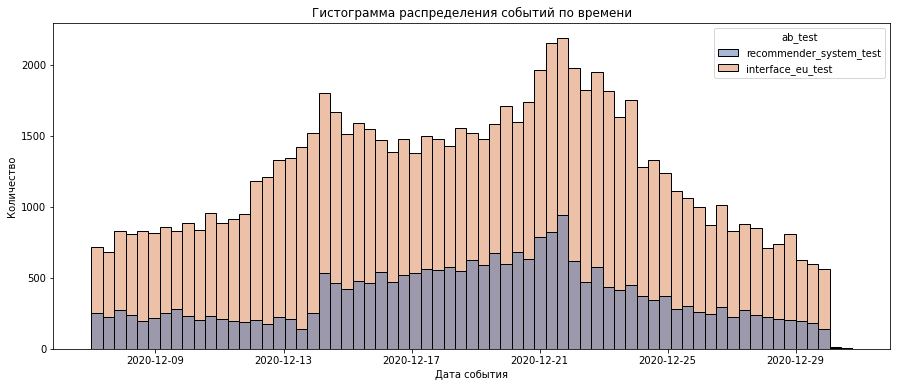

In [88]:
#гистограмма распределения событий по времени

sns.set_palette('deep')
f, ax = plt.subplots(figsize=(15,6 ))
sns.histplot(data = data, x = 'event_dt', hue = 'ab_test') 
plt.title(f'Гистограмма распределения событий по времени')
plt.xlabel('Дата события')
plt.ylabel('Количество')
plt.show()

- эксперименты проведены в одно и то же время
- в обоих экспериментах после 29 декабря практически нет событий, т.е. фактически наш эксперимент закончился не 30, а 29 декабря включительно.
- исходя из гистограммы времени мы видим, что не все пользователи прожили в эксперименте 14 дней. Пользователи привлеченные 21 декабря участвовали в эксперименте всего 9 дней

### Аудитория: 15% новых пользователей из региона EU

In [89]:
#посмотрим набор данных нашего теста по региону
data[data['ab_test'] == 'recommender_system_test']['region'].value_counts()

EU           26290
N.America      942
APAC           259
CIS            233
Name: region, dtype: int64

*Кроме Европы в нашем тесте представлены пользователи и из других регионов.*

In [90]:
# найдем раннюю и позднюю дату регистрации пользователей в таблице ab_users
ab_users['first_date'].agg({'min', 'max'})

max   2020-12-23
min   2020-12-07
Name: first_date, dtype: datetime64[ns]

In [91]:
# сколько пользователей составляют 15% от зарегистрировавшихся до 21 декабря включительно
len(ab_users[(ab_users['first_date'] <= '2020-12-21') & (ab_users['region'] == 'EU')])*0.15

6351.0

In [92]:
# сколько уникальных пользователей из Европы в нашем эксперименте
data[(data['ab_test'] == 'recommender_system_test') & (data['region'] == 'EU')]['user_id'].nunique()

6351

*Здесь все верно, действительно в нашем тесте 15% новых пользователей от зарегистрировавшихся из региона EU*

### Итоги

**С ТЗ не совпадает дата окончания теста, соответственно не все пользователи "прожили" в эксперименте 14 дней. Кроме того в тесте представлены не только пользователи из Европы, но и пользователи из других регионов. Ожидаемый результат по метрикам проверим далее. Остальные пунктф ТЗ выполнены корректно**


## Дополнительные проверки
- пользователи, без событий
- пересечение пользователей
- наложение маркетинговых событий
- равномерность распределения пользователей по тестовым группам и правильность их формирования

### Пользователи без событий

In [93]:
# сколько пользователей с пропусками в графе "event_name", 
data[(data['event_name'].isna() == True) & (data['ab_test'] == 'recommender_system_test')]['user_id'].nunique()

3026

Предположим, что имел место либо технический сбой, либо изначально у нас набираются пользователи разных поведенческих характеристик. Далее оценим как набирались такие пользователи по группам теста, а также оценим их принадлежность к региону и используемому девайсу.

In [94]:
null_events = data[(data['event_name'].isna() == True) & (data['ab_test'] == 'recommender_system_test')]

In [95]:
# группируем по дате регистрации и принадлежности к группе теста/девайсу/региону и смотрим сколько пользователей привлекли
cnt_user_null_event = null_events.groupby(['group', 'first_date'])['user_id'].nunique().reset_index()

device_null_event = null_events.groupby(['device', 'first_date'])['user_id'].nunique().reset_index()

region_null_event = null_events.groupby(['region', 'first_date'])['user_id'].nunique().reset_index()

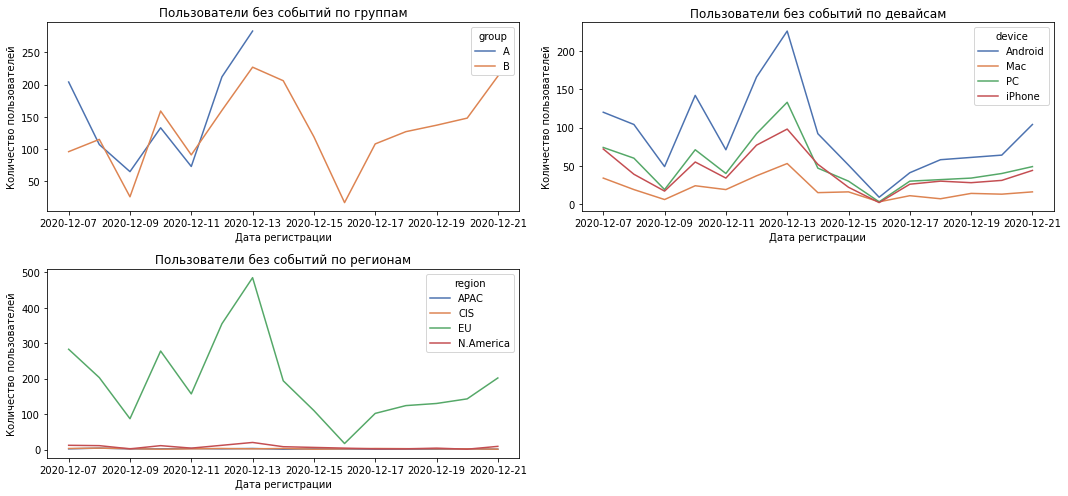

In [96]:
# строим графики для распределения количества пользователей без событий по 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,7))
ax = ax.flatten()

sns.lineplot(data = cnt_user_null_event, x = 'first_date', y = 'user_id', hue='group', ax=ax[0]) 
sns.lineplot(data = device_null_event, x = 'first_date', y = 'user_id', hue='device', ax=ax[1]) 
sns.lineplot(data = region_null_event, x = 'first_date', y = 'user_id', hue='region', ax=ax[2])

ax[0].set_title('Пользователи без событий по группам')
ax[1].set_title('Пользователи без событий по девайсам')
ax[2].set_title('Пользователи без событий по регионам')
ax[0].set_xlabel('Дата регистрации')
ax[1].set_xlabel('Дата регистрации')
ax[2].set_xlabel('Дата регистрации')
ax[0].set_ylabel('Количество пользователей')
ax[1].set_ylabel('Количество пользователей')
ax[2].set_ylabel('Количество пользователей')

fig.delaxes(ax[-1])
fig.tight_layout()
fig.show()

Видим, что в экспериментальной группе у нас на протяжении всего набора участников теста, есть пользователи без событий, в контрольной группе такие пользователи перестали набираться с 13 декабря, то есть через неделю после эксперимента.

Проблемы возникли с пользователями из Европы на андроидах. Пользователи из других регионов показали примерно одинаковые цифры набора пользователей, которые не идут дальше регистрации. Европа - большой отрыв и качели.

На Европу работа идет хуже? - может быть это технические проблемы, может быть проблемы интерфейса для европейского пользователя (второй эксперимент в наших данных как раз проверяет изменения интерфейса для европейских пользователей), может быть провал удержания тоже в разрезе европейского пользователя (поэтому начали вести параллельно проверяемый нами эксперимент).

`!!!` Все эти пользователи в каждой группе будут влиять на построение воронки: если мы присвоим им event_name - login, то это сдвинет показатель конверсии перехода на следующий этап воронки и в целом по воронке в худшую сторону. Если бы такие пользователи набирались в течение всего эксперимента и в группе А, можно было бы их оставить, но в нашей ситуации они могут сдвинуть результаты теста.

**Примем, что данные пользователи включены в тест некорректно и удалим их из нашей выборки участников теста. На дальнейших этапах оценим хватает ли нам количества пользователей для корректного проведения АВ-теста.**

In [97]:
# удаление таких пользователей проведем изменением типа объединения таблиц, с left на inner
data = pd.merge(x_user, ab_events, on='user_id', how='inner')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106625 entries, 0 to 106624
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     106625 non-null  object        
 1   group       106625 non-null  object        
 2   ab_test     106625 non-null  object        
 3   first_date  106625 non-null  datetime64[ns]
 4   region      106625 non-null  object        
 5   device      106625 non-null  object        
 6   event_dt    106625 non-null  datetime64[ns]
 7   event_name  106625 non-null  object        
 8   details     15416 non-null   float64       
 9   event_day   106625 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 8.9+ MB


In [98]:
# рассчитываем лайфтайм для каждой покупки
data['lifetime'] = (
        data['event_dt'] - data['first_date']
    ).dt.days

In [99]:
data = data.loc[data['lifetime'] <= 14]


### Пересечение пользователей

In [101]:
# смотрим пересечения с конкурирующим тестом, сохраняем user_id  в списк
crossing = list(data.groupby('user_id')['ab_test'].nunique().reset_index().query('ab_test > 1')['user_id'])
len(crossing)

887

In [102]:
# формируем датафрейм только с пересекающимися в двух экспериментах user_id
crossing_data = data[data['user_id'].isin(crossing)]

# создаем список user_id, которые вошли в группу В конкурирующего теста
b_exp = list(
    crossing_data.loc[
        (
        crossing_data['ab_test'] == 'interface_eu_test'
    ) & (
        crossing_data['group'] == 'B'
    )
    ]['user_id'].unique()
)

len(b_exp)

431

In [103]:
# формируем датафрейм нашего теста, оставляем в нем пользователей из группы В конкурирующего теста
exp_data = data.loc[data['ab_test'] == 'recommender_system_test']
exp_data_cross = exp_data[exp_data['user_id'].isin(b_exp)]

# распределение пользователей по группам теста
exp_data_cross.groupby('group')['user_id'].nunique()

group
A    325
B    106
Name: user_id, dtype: int64

**Мы видим, что пересекающиеся пользователи распределены между группами нашего теста, такое распределение пересекающихся пользователей будем считать допустимым (будем считать, что эксперименты независимы и проходят в разных слоях ресурса, хотя такое переиспользование трафика, для тестов, проводящихся в одни и те же даты, некорректно). Оставим этих пользователей и проведем тест.**

### Наложение маркетинговых событий

In [104]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [105]:
marketing_events[marketing_events['start_dt'] >= '2020-12-07']

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Маркетинговое событие CIS New Year Gift Lottery хоть и попадает в объявленные в ТЗ временные границы эксперимента, но по факту не затрагивает его, так ка фактически эксперимент завершен 29 декабряю

Посмотрим влияние события Christmas&New Year Promo, оно захватывает события нашего проекта совершенные с 25 по 29 декабря. Посмотрим количество событий в дни проведения эксперимента.

In [106]:
marketing_events[(marketing_events['start_dt'] >= '2020-12-07') & (marketing_events['regions'].apply(lambda x: 'EU' in str(x)) == True)]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


In [107]:
# фильтруем по дате и смотрим количество каждого события
event = exp_data[exp_data['event_dt'] >= '2020-12-25']
event_purchase = event[event['event_name'] == 'purchase'].groupby(
    ['event_day', 'group']
)['event_name'].count().reset_index()

event_page = event[event['event_name'] == 'product_page'].groupby(
    ['event_day', 'group']
)['event_name'].count().reset_index()

event_cart = event[event['event_name'] == 'product_cart'].groupby(
    ['event_day', 'group']
)['event_name'].count().reset_index()


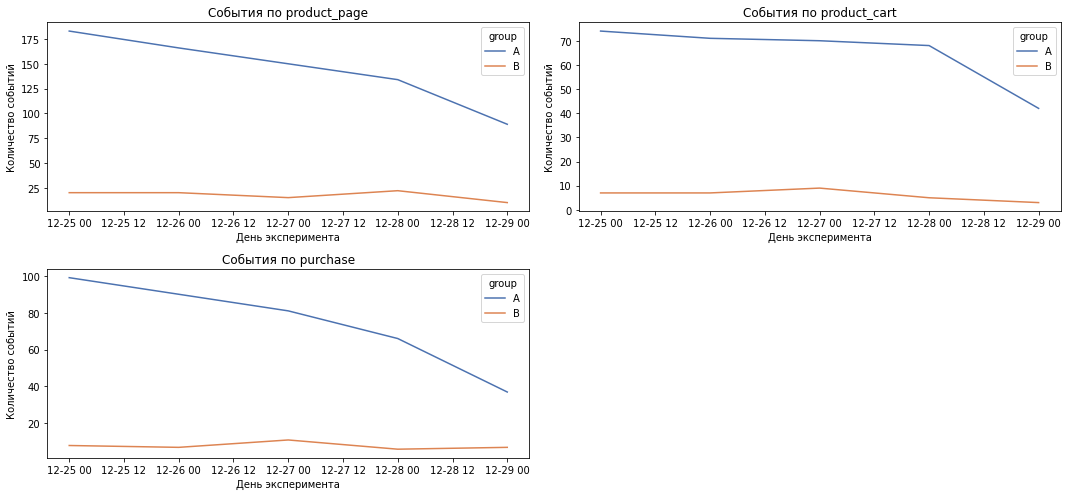

In [108]:
# смотрим количество событий
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,7))
ax = ax.flatten()

sns.lineplot(data = event_page, x = 'event_day', y = 'event_name', hue='group', ax=ax[0]) 
sns.lineplot(data = event_cart, x = 'event_day', y = 'event_name', hue='group', ax=ax[1]) 
sns.lineplot(data = event_purchase, x = 'event_day', y = 'event_name', hue='group', ax=ax[2]) 

ax[0].set_title('События по product_page')
ax[1].set_title('События по product_cart')
ax[2].set_title('События по purchase')
ax[0].set_xlabel('День эксперимента')
ax[1].set_xlabel('День эксперимента')
ax[2].set_xlabel('День эксперимента')
ax[0].set_ylabel('Количество событий')
ax[1].set_ylabel('Количество событий')
ax[2].set_ylabel('Количество событий')

fig.delaxes(ax[-1])
fig.tight_layout()
fig.show()

**По всем пунктам в группе А мы видим снижение показателей, в группе B тоже снижение, но графики все же ровнее, кроме того показатель покупок в группе B даже показывает рост 27 и 29 декабря.**

**Сказать однозначно, что повлияло на группу B - маркетинговое событие или изменения, связанные с внедрением улучшенной рекомендательной системы - затруднительно (у нас нет описания этой маркетинговой активности), но то, что мы видим на графиках - все же предполагает бОльшее влияние экспериментальных изменений, так как группа А все же показывает спад.**

**И нужно заметить, временной период для эксперимента в идеале должен быть свободен от маркетинговых событий, напрямую влияющих на нужные в эксперименте метрики, чтобы не искажать результаты теста, в нашем случае это правило не соблюдено**

### Равномерность распределения пользователей по тестовым группам и правильность их формирования

АВ-тест предполагает большую схожесть групп пользователей, для чистоты эксперимента. Оценим похожесть пользователей, посмотрим пропорции заполнения групп теста по параметрам пользователя: решион и девайс.

In [109]:
# колuичество пользователей в эксперименте
print(exp_data['user_id'].nunique())
exp_data.groupby('group')['user_id'].nunique()

3675


group
A    2747
B     928
Name: user_id, dtype: int64

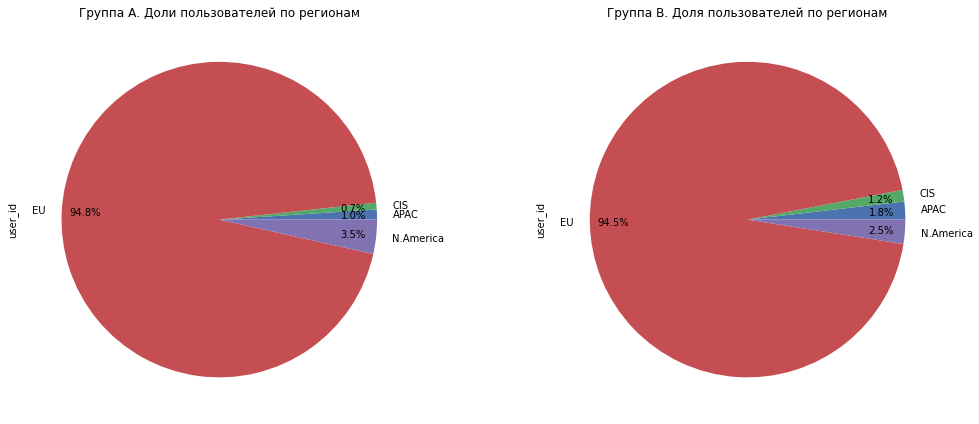

In [110]:
# формирование групп, доли по параметру region
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
ax = ax.flatten()
with plt.style.context('seaborn-deep'):
    exp_data[exp_data['group'] == 'A'].groupby('region')['user_id'].nunique().plot(
        kind='pie', autopct='%1.1f%%', title='Группа А. Доли пользователей по регионам', pctdistance=0.85, ax=ax[0]
) 
    exp_data[exp_data['group'] == 'B'].groupby('region')['user_id'].nunique().plot(
        kind='pie', autopct='%1.1f%%', title='Группа В. Доля пользователей по регионам', pctdistance=0.85, ax=ax[1]
)
fig.tight_layout()
fig.show()

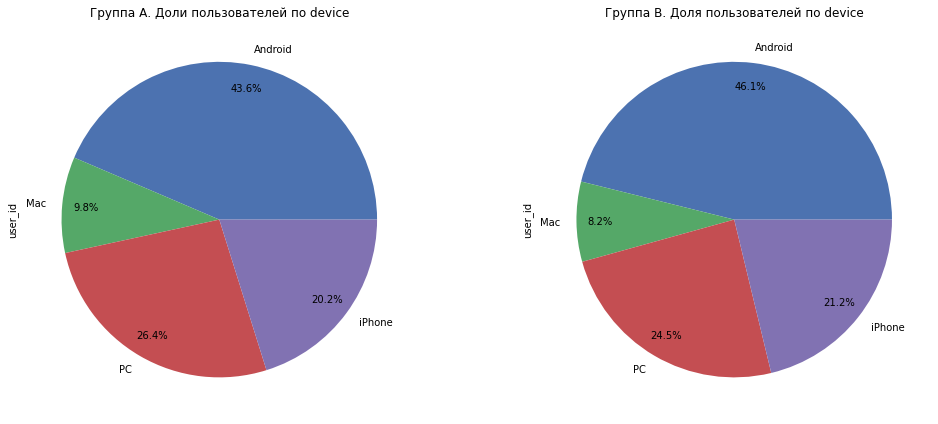

In [111]:
# формирование групп, доли по параметру device
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
ax = ax.flatten()
with plt.style.context('seaborn-deep'):
    exp_data[exp_data['group'] == 'A'].groupby('device')['user_id'].nunique().plot(
        kind='pie', autopct='%1.1f%%', title='Группа А. Доли пользователей по device', pctdistance=0.85, ax=ax[0]
) 
    exp_data[exp_data['group'] == 'B'].groupby('device')['user_id'].nunique().plot(
        kind='pie', autopct='%1.1f%%', title='Группа В. Доля пользователей по device', pctdistance=0.85, ax=ax[1]
)
fig.tight_layout()
fig.show()

**Доли пользователей по регионам и девайсам очень похожи. Группы, относительно характеристик пользователей, заполнены корректно.**

### Итоги

- Мы удалили пользователей, не совершавших событий (для корректности рассчета воронки)
- Оставили пересекающихся пользователей: 1. Пересекающиеся пользователи из группы А конкурирующего по времени проведения теста - не видели изменений, могут быть оставлены; 2. Пересекающиеся пользователи группы В распределены по группам нашего теста, большая часть вошла в группу А. Повторное использование пользователей в АВ-тестах имеет мето быть, но в идеале тесты не должны пересекаться во времени. У нас вариант не идеальный.
- Маркетинговое событие охватывало последние 4 дня эксперимента, но существенного влияния не оказало.
- По признакам принадлежности к региону и к типу девайса - группы набраны корректно

## Исследовательский анализ данных

Ответим на вопросы:
- Количество событий на пользователя одинаково распределены в выборках?
- Как число событий в выборках распределено по дням?
- Как меняется конверсия в воронке в выборках на разных этапах?
- Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

In [112]:
# обзорная функция
def picture(data):
    count_event = data['event_name'].nunique()
    print ('Уникальных событий -', count_event)
    
    total_event = data['event_name'].count()
    print ('Всего событий -', total_event)
    
    count_user = data['user_id'].nunique()
    print('Пользователей  -', count_user)
    
    d = data.groupby('user_id')['event_name'].count().reset_index()
    i = d['event_name'].mean()
    print(f'В среднем на пользователя приходится {i:.2f} событий')
    
    print('Мы располагаем данными с', exp_data['event_day'].min(), 'по', exp_data['event_day'].max())
   

In [113]:
picture(exp_data)

Уникальных событий - 4
Всего событий - 24070
Пользователей  - 3675
В среднем на пользователя приходится 6.55 событий
Мы располагаем данными с 2020-12-07 по 2020-12-29


### Количество событий на пользователя в выборках?

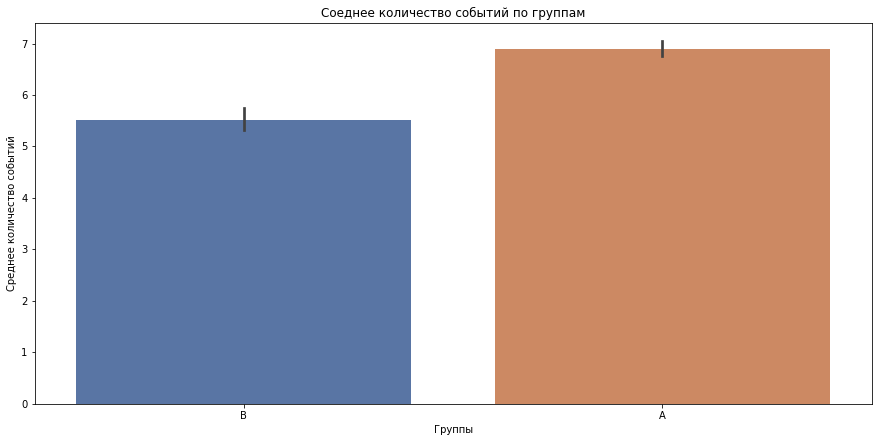

In [114]:
cnt_event = exp_data.groupby(['user_id','group'])['event_name'].count().reset_index()

fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(data = cnt_event, x = 'group', y = 'event_name')
plt.title('Соеднее количество событий по группам')
plt.xlabel('Группы')
plt.ylabel('Среднее количество событий')
plt.show()

**Среднее количество событий на пользователя в группах немного различаются, в среднем примерно на 1 событие больше делает пользователь из группы А.**

### Как число событий в выборках распределено по дням?

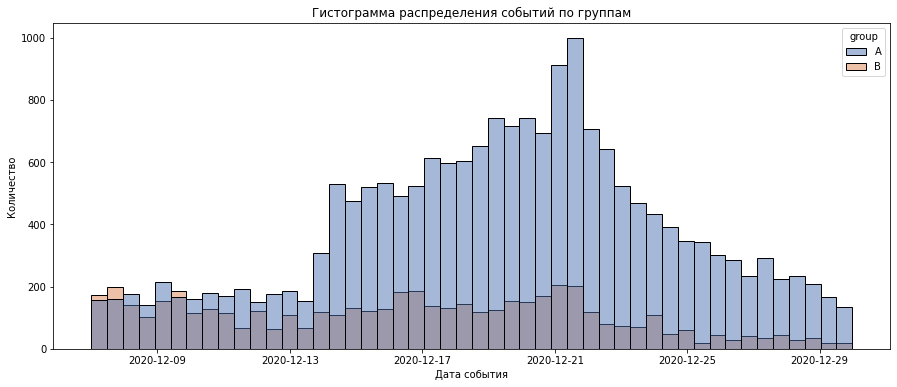

In [115]:
# построим гистограмму
f, ax = plt.subplots(figsize=(15,6 ))
sns.histplot(data = exp_data, x = 'event_dt', hue = 'group') 
plt.title('Гистограмма распределения событий по группам')
plt.xlabel('Дата события')
plt.ylabel('Количество')
plt.show()

 - **В группе B число событий распределено без резких подъемов и спусков до 21-21 декабря, далее количество немного снижается и колеблется вокруг этого значения, тенденция к уменьшению событий в конце эксперимента видна**
 - **В группе А, число событий до 14 декабря также варьируется слабо, далее идет повышение числа событий до 21-22 декабря и далее спад.**

### Как меняется конверсия в воронке в выборках на разных этапах?

`!` Помним о том, что пользователь не обязательно последовательно проходит все этапы, если есть реклама/рассылки и прочие маркетинговые активности (а они у нас есть), возможен переход сразу на страницу товара.

Далее посмотрим:

- какие события есть, как часто они встречаются
- сколько пользователей совершали каждое из этих событий по группам теста
- посчитаем воронку событий по группам теста

In [116]:
# посмотрим какие события есть в логах и как часто они встречаются
exp_data.pivot_table(index='event_name', columns='group', values = 'user_id', aggfunc='count').sort_values(
    by=['A','B'], ascending=False
)

group,A,B
event_name,,
login,8400,2493
product_page,5415,1331
purchase,2613,640
product_cart,2519,659


Событий в product_cart больше, чем покупок в обеих группах, что может быть связано с наличием быстрой покупки с product_page

In [117]:
# считаем воронку событий, исключая туториал
funnel_count_A = exp_data.query('group== "A"').groupby('event_name').agg({'user_id':'nunique'}).sort_values(
    by='user_id', ascending=False
).reset_index()
funnel_count_A

,event_name,user_id
0,login,2747
1,product_page,1780
2,purchase,872
3,product_cart,824


In [118]:
funnel_count_B = exp_data.query('group== "B"').groupby('event_name').agg({'user_id':'nunique'}).sort_values(
    by='user_id', ascending=False
).reset_index()
funnel_count_B

,event_name,user_id
0,login,927
1,product_page,523
2,purchase,256
3,product_cart,255


In [119]:
# добавляем конверсию
def count_funnel(data):
    funnel_list = list(data['user_id'])
    conv = []
    for i in funnel_list:
        x = i/funnel_list[0]
        conv.append(x)
    conversion = pd.Series(conv)
    data['conversion'] = round(conversion*100,1)
    return data

In [120]:
funnel_A = count_funnel(funnel_count_A).reindex([0,1,3,2])
funnel_A

,event_name,user_id,conversion
0,login,2747,100.0
1,product_page,1780,64.8
3,product_cart,824,30.0
2,purchase,872,31.7


In [121]:
funnel_B = count_funnel(funnel_count_B).reindex([0,1,3,2])
funnel_B

,event_name,user_id,conversion
0,login,927,100.0
1,product_page,523,56.4
3,product_cart,255,27.5
2,purchase,256,27.6


- **Продуктовые воронки сформировали согласно логике перехода с этапа на этап при стандартном пути от логина до покупки, обе воронки похожи тем, что покупок больше, чем просмотров корзины - возможность быстрой оплаты покупки со страницы товара востребована у пользователя.**
- **В обеих воронках достаточно много пользователей теряется на переходе с login в product_page, на следующем шаге - переход в product_cart|purchase, успешнее выглядит конверсия в воронке группы B, но это следует проверить далее экспериментально.**


### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

Глобальных проблем четыре:
- пересечение пользователей,
- пользователи без событий,
- наложение маркетинговой активности - три этих фактора, которые могут влиять на результаты теста мы уже обработали.

Теперь обратимся к:
- не все пользователи прожили в тесте 14 дней

In [124]:
# максимум и минимум по дате событий для группы А
exp_data.query('group == "A"')['event_day'].agg({'min', 'max'})

max    2020-12-29
min    2020-12-07
Name: event_day, dtype: object

In [125]:
# максимум и минимум по дате событий для группы В
exp_data.query('group == "B"')['event_day'].agg({'min', 'max'})

max    2020-12-29
min    2020-12-07
Name: event_day, dtype: object

За остановку теста возьмем 29 декабря. Тогда время жизни в тесте у пользователей, зарегистрированных 21 декабря снижается до 9 дней.

Посмотрим какое время нужно пользователю, чтобы дойти до покупки, и примем решение.

In [126]:
# считаем время прохождения пользователя до первой покупки
data['timing'] = data['event_dt'] - data['first_date']
data[
    (data['ab_test'] == 'recommender_system_test') & (data['event_name']=='purchase')
].groupby('user_id').agg({'timing':'first'})['timing'].describe()

count                         1128
mean     0 days 12:12:58.184397163
std      0 days 08:20:27.740025007
min                0 days 00:00:17
25%         0 days 06:08:46.500000
50%                0 days 11:58:42
75%                0 days 18:12:09
max                6 days 23:09:45
Name: timing, dtype: object

Среднее и медианное время прохождения воронки укладываются в пределы 1 дня, судя по std и максимуму, прохождение воронки более чем за 1 день редкость, а максимум вполне можно считать выбросом, аномальным значением.

В связи с этим, не будем удалять из теста пользователей, не проживших 14 дней, так как даже те, которые зарегистрировались 21 декабря, "живут" в тесте 9 дней, а у нас максимум до покупки 6.

### Итоги
- В среднем примерно на 1 событие больше делает пользователь из группы А.
- В группе B число событий распределено без резких подъемов и спусков до 21-21 декабря, далее количество немного снижается и колеблется вокруг этого значения, тенденция к уменьшению событий в конце эксперимента видна
- В группе А, число событий до 14 декабря также варьируется слабо, далее идет повышение числа событий до 21-22 декабря и далее спад.
- Не удаляем из теста пользователей, не проживших 14 дней
- Отфильтровали события, удалили те, которые совершены пользователями после 14 дня жизни в тесте

## Проведение теста

Разделим данные по выборкам, посмотрим количественное значение, посмотрим необходимое число пользователей в тесте с помощью интерактивных калькуляторов и сравним с нашим.

In [127]:
# количество участников теста
exp_data['user_id'].nunique()

3675

In [128]:
# распределение по группам
exp_data.groupby('group')['user_id'].nunique()

group
A    2747
B     928
Name: user_id, dtype: int64

После удаления пользователей, без событий, наша выборка перестала соответствовать ТЗ, из необходимых 6000 осталось 3675 участников теста. Участников в группе А больше, чем в группе B

In [129]:
# делим данные на выборки по группам
sample_A = exp_data.loc[exp_data['group'] == 'A']
sample_B = exp_data.loc[exp_data['group'] == 'B']

Посмотрим на интерактивных калькуляторах сколько пользователей нам нужно, чтобы увидеть изменение конверсии на 10%, если это изменение действительно существует. Помним что нас интересуют показатели конверсии перехода по воронке, соответственно базовый коэффициет в калькуляторе зададим по конверсии воронки группы А -для максимального и минимального значения и посмотрим хватает ли нам пользователей при уровне значимости alpha = 0.05.

Используемый калькулятор: https://www.optimizely.com/sample-size-calculator/?conversion=30&effect=10&significance=95

- для базовой конверсии 64% (конверсия в переход login ➡️ product_page) достаточно 540 участников для каждой группы
- для базовой конверсии 30% (конверсия в переход ➡️ product_cart) достаточно 2800 участников для каждой группы

**Нам достаточно пользователей, чтобы доверять результату теста по конверсии login ➡️ product_page, и не достаточно - для уверенности в результатах теста в остальных переходах. Но наш тест изначально был с нарушением условий тестирования, с неполными данными - поэтому примем в тест то количество участников, что осталось после обработки и проверки данных.**

**Сформулируем гипотезу для z-теста:**

- H0 - доли уникальных посетителей, побывавших на этапе воронки, не имеют статистически значимых различий
- H1 - между долями уникальных посетителей, побывавших на этапе воронки, есть статистически значимые различия

*Так как на одних и тех же данных будет проводиться множественный тест, применим поправку Бонферрони к уровню значимости.*

In [130]:
# подготовим функцию для эксперимента
def z_test(data1, data2, value, alpha=0.05/3):
   
    events = []
    users = []
    
    
# заполняем список events - количество уникальных пользователей в событии    
    x = data1.loc[data1['event_name'] == value]['user_id'].nunique()
    y = data2.loc[data2['event_name'] == value]['user_id'].nunique()
    events.append(x)
    events.append(y)
# заполняем список users - количество уникальных пользователей  
    x_s = data1['user_id'].nunique()
    y_s = data2['user_id'].nunique()
    users.append(x_s)
    users.append(y_s)    
    
# пропорция успешно оплативших по группам
    p1 = events[0]/users[0]
    p2 = events[1]/users[1]
    print(f'Конверсия группы А: {p1}')
    print(f'Конверсия группы B: {p2}')
    
# пропорция успехов в комбинированном датасете
    p_combined = (events[0] + events[1]) / (users[0] + users[1])
    
# разница пропорций в датасетах
    difference = p1-p2
    
# считаем статистику в std нормального распределения
    z_value = difference/mth.sqrt(
    p_combined * (1 - p_combined)
    * (1 / users[0] + 1 / users[1]))
    
# задаем стандартное нормальное распределение
    distr = st.norm(0,1)
    
# считаем p_value
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print ('p-значение:', p_value)
    
# интерпретация результата
    if p_value < alpha:
        print(
            f'Событие - {value} \n Отвергаем нулевую гипотезу: между долями есть значимая разница'
        )
    else:
        print(
            f'Событие - {value} \n Не получилось отвергнуть нулевую гипотезу:нет оснований считать доли разными'
        )

In [131]:
value_list = ['product_page', 'product_cart', 'purchase']
# запускаем тест
for v in value_list:
    z_test(sample_A, sample_B, v)
    print('--------------------------------------')

Конверсия группы А: 0.6479796141244994
Конверсия группы B: 0.5635775862068966
p-значение: 4.310980554755872e-06
Событие - product_page 
 Отвергаем нулевую гипотезу: между долями есть значимая разница
--------------------------------------
Конверсия группы А: 0.2999635966508919
Конверсия группы B: 0.27478448275862066
p-значение: 0.14534814557238196
Событие - product_cart 
 Не получилось отвергнуть нулевую гипотезу:нет оснований считать доли разными
--------------------------------------
Конверсия группы А: 0.3174372042227885
Конверсия группы B: 0.27586206896551724
p-значение: 0.017592402663314743
Событие - purchase 
 Не получилось отвергнуть нулевую гипотезу:нет оснований считать доли разными
--------------------------------------


### Итоги
- **между долями уникальных посетителей, побывавших на этапе воронки product_page, есть статистически значимые различия - несмотря на уменьшение количества участников теста(снижение его мощности), этих пользователей хватает, чтобы доверять результатам и увидеть различие в 10%**
- **также есть статистически значимые различия межу долями уникальных посетителей на этапе воронки purchase - но здесь вероятность ошибки больше, так как не хватает участников теста для обнаружения разницы конверсий в 10%**
- **доли уникальных посетителей, побывавших на этапе воронки - product_cart, не имеют статистически значимых различий - здесь также вероятность ошибки больше, так как не хватает участников теста для обнаружения разницы конверсий в 10%** 

## Результаты оценки теста

**Тест спланирован и проведен некорректно:**
- есть пересечение аудитории с конкурирующим по времени тестом (распределение пересекающихся пользователей посчитали допустимым, предположив, что эксперименты независимы и проходят в разных слоях ресурса, хотя такое переиспользование трафика, для тестов, проводящихся в одни и те же даты, некорректно)
- есть наложение маркетинговой активности на последние 4 дня эксперимента
- кроме того в тесте значительное количество пользователей без событий (были удалены)
- ранняя остановка (29 декабря, а не 4 января)
- не все пользователи прожили в тесте 14 дней, пользователи зарегистрированные 21 декабря в тесте всего 9 дней (мы выяснили что, по воронке большинство пользователей проходит до покупки за 1 день, поэтому пользователей не проживших 14 дней оставили)
- целевая аудитория теста, не только пользователи из Европы
- в результате корректировки по участникам теста (удаление пользователей без событий) из предполагаемых 6000 остались 3675 пользователей, такго количества не хватает для корректного проведения всего теста
- сильный дисбаланс в пользователях между группами: A - 2747 пользователей, В - 928 пользователей

Обработав материалы теста, мы удалили пользователей без событий (снизили мощность теста, но сохранили достоверность конверсии на первом этапе воронки).

**Результаты теста:**
- между долями уникальных посетителей, побывавших на этапе воронки product_page, есть статистически значимые различия - пользователей хватает, чтобы доверять результатам и увидеть различие в 10%
- есть статистически значимые различия межу долями уникальных посетителей на этапе воронки purchase - есть вероятность ошибки, так как не хватает участников теста для обнаружения разницы конверсий в 10%
- доли уникальных посетителей, побывавших на этапе воронки - product_cart, не имеют статистически значимых различий - зесть вероятность ошибки, так как не хватает участников теста для обнаружения разницы конверсий в 10%
- предполагалось, что конверсия группы В станет выше, чем в группе А на 10%, но анализ показал, что уже на этапе первого перехода по воронке конверсия группы А - 66%, конверсия группы В - 57% - что не соответсвует и нашему ТЗ

**Рекомендательную систему по итогу проведения теста внедрять не стоит**

` - Из-за многочисленных нарушений технического задания, а также некорректного планирования и проведения теста (есть пересекающиеся пользователи из конкурирующего теста, наложение маркетингового события, несоответствие планируемой аудитории ТЗ, проблемы с наличием большого количества пользователей без событий) корректность проведения теста, как и валидность результата, вызывает вопросы.`

`- Кроме того результаты теста на очищенных данных также можно признать относительными, так как после фильтрации в тесте из планируемых 6000 осталось меньше половины (2747 участников), что снизило мощность теста и повысило вероятность ошибки`

`- Предварительные рассчеты конверсии в воронке показали, что конверсия группы В по этапам воронки или меньше, или равна конверсии группы А (роста нет)`